# Spellcheck LLM dengan Ollama di Google Colab

Notebook ini melakukan koreksi ejaan pada kalimat Bahasa Indonesia menggunakan LLM (Ollama) dan menghitung akurasi hasil koreksi.

In [26]:
! pip install ipywidgets pandas requests matplotlib numpy

import ipywidgets as widgets
from IPython.display import display
import pandas as pd

uploader = widgets.FileUpload(accept='.csv', multiple=False)
process_button = widgets.Button(description="Proses File")
output = widgets.Output()

# Gunakan variabel global agar bisa diakses di cell lain
uploaded_filename = None

def on_process_clicked(b):
    global uploaded_filename
    with output:
        output.clear_output()
        if uploader.value:
            file_info = uploader.value[0]
            uploaded_filename = file_info['name']
            # Simpan ke disk lokal
            with open(uploaded_filename, 'wb') as f:
                f.write(file_info['content'])
            print(f"File berhasil disimpan sebagai: {uploaded_filename}")
        else:
            print("Belum ada file yang di-upload.")

process_button.on_click(on_process_clicked)
display(widgets.VBox([uploader, process_button, output]))

## 1. Dataset & Utilitas Data

In [27]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

class SpellingDataset:
    def __init__(self, error_sentences=None, correct_sentences=None):
        self.error_sentences = error_sentences or []
        self.correct_sentences = correct_sentences or []
    def add_sample(self, error_sentence, correct_sentence):
        self.error_sentences.append(error_sentence)
        self.correct_sentences.append(correct_sentence)
    def get_all_samples(self):
        return list(zip(self.error_sentences, self.correct_sentences))
    def __len__(self):
        return len(self.error_sentences)

def get_sample_indonesian_dataset(csv_path):
    print(f"Loading dataset from {csv_path}")
    df = pd.read_csv(csv_path)
    dataset = SpellingDataset()
    for _, row in df.iterrows():
        dataset.add_sample(row['kalimat_salah'], row['kalimat_awal'])
    return dataset

if uploaded_filename:
    dataset = get_sample_indonesian_dataset(uploaded_filename)
    kalimat_salah = dataset.error_sentences
    kalimat_benar = dataset.correct_sentences
    print(f"Jumlah data: {len(dataset)}")
else:
    print("File belum di-upload atau diproses.")


Loading dataset from BIndo_output_real-word_error.csv
Jumlah data: 499


## 2. Client Ollama untuk Koreksi Ejaan

In [28]:
import requests

class OllamaClient:
    def __init__(self, base_url="http://host.docker.internal:11434"):
        self.base_url = base_url
        self.api_endpoint = f"{self.base_url}/api/generate"
    def correct_spelling(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = (
                "You are an assistant who helps to correct the spelling of Indonesian sentences."
                "Correct only the wrong spelling, do not add explanations, do not add other words or do not add punctuation words."
                "Do not change the explanation, do not change other words or do not change punctuation."
                "Return only the corrected sentences."
            )
        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""

## 3. Fungsi Evaluasi Akurasi

In [29]:
# Fungsi sederhana untuk mengukur akurasi LLM
import numpy as np

def skema_exact_match(hasil_prediksi, target_benar):
    if len(hasil_prediksi) != len(target_benar):
        raise ValueError("Jumlah prediksi dan target harus sama")
    hasil_per_item = [pred == target for pred, target in zip(hasil_prediksi, target_benar)]
    akurasi = sum(hasil_per_item) / len(hasil_per_item) if hasil_per_item else 0
    return akurasi, hasil_per_item

def skema_kata_per_kata(hasil_prediksi, target_benar):
    if len(hasil_prediksi) != len(target_benar):
        raise ValueError("Jumlah prediksi dan target harus sama")
    
    akurasi_per_kalimat = []
    
    for pred, target in zip(hasil_prediksi, target_benar):
        # Split kalimat menjadi kata-kata
        pred_words = pred.split()
        target_words = target.split()
        
        # Hitung jumlah kata yang benar
        total_words = max(len(pred_words), len(target_words))
        
        if total_words == 0:
            # Kasus khusus jika kalimat kosong
            akurasi_kata = 1.0 if pred == target else 0.0
        else:
            # Hitung kata yang sama pada posisi yang sama
            correct_words = sum(1 for i in range(min(len(pred_words), len(target_words))) 
                             if pred_words[i] == target_words[i])
            akurasi_kata = correct_words / total_words
        
        akurasi_per_kalimat.append(akurasi_kata)
    
    # Rata-rata akurasi dari semua kalimat
    avg_akurasi = np.mean(akurasi_per_kalimat) if akurasi_per_kalimat else 0
    
    return avg_akurasi, akurasi_per_kalimat

## 4. Proses Koreksi Ejaan dengan LLM

In [30]:
import time

client = OllamaClient()
hasil_llm_model1 = []
hasil_llm_model2 = []
hasil_llm_model3 = []
processing_times = []

for i, kalimat in enumerate(kalimat_salah):
    print(f"Input   : {kalimat}")
    start = time.time()
    hasil = client.correct_spelling(kalimat, "llama3.1:8b")
    end = time.time()
    hasil_llm_model1.append(hasil)
    processing_times.append(end-start)
    print(f"Target  : {kalimat_benar[i]}")
    print(f"LLM 1     : {hasil}")
    print(f"Waktu   : {end-start:.2f}s\n")

# for i, kalimat in enumerate(kalimat_salah):
#     print(f"Input   : {kalimat}")
#     start = time.time()
#     hasil = client.correct_spelling(kalimat, "qwen2.5:7b")
#     end = time.time()
#     hasil_llm_model2.append(hasil)
#     processing_times.append(end-start)
#     print(f"Target  : {kalimat_benar[i]}")
#     print(f"LLM 2     : {hasil}")
#     print(f"Waktu   : {end-start:.2f}s\n")

Input   : Bunyi ala?
Target  : Bunyi apa?
LLM 1     : Bunyi apa?
Waktu   : 3.23s

Input   : Siap-siap belanja.
Target  : Siap-siap belajar.
LLM 1     : Siap-siap untuk belanja.
Waktu   : 0.15s

Input   : Diskusikan gambar sampul di atas dengar menjawab pertanyaan-pertanyaan ini.
Target  : Diskusikan gambar sampul di atas dengan menjawab pertanyaan-pertanyaan ini.
LLM 1     : Diskusikan gambar sampul di atas dan menjawab pertanyaan-pertanyaan ini.
Waktu   : 0.35s

Input   : Apa yang kalian lihat padahal gambar di atas?
Target  : Apa yang kalian lihat pada gambar di atas?
LLM 1     : Apa yang kalian melihat pada gambar di atas?
Waktu   : 0.21s

Input   : Menurut kalian, apa isu ceritanya?
Target  : Menurut kalian, apa isi ceritanya?
LLM 1     : Masalahnya
Waktu   : 0.08s

Input   : Simak guru membacakan cerita kini.
Target  : Simak guru membacakan cerita ini.
LLM 1     : Simaklah guru membacakan cerita itu kini.
Waktu   : -264.29s

Input   : Itu bila boni.
Target  : Itu bola boni.
LLM 1 

## 5. Evaluasi & Visualisasi Akurasi

====== Hasil Evaluasi ======
Skema 1 - Exact Match Accuracy : 0.2222
Skema 2 - Word Match Accuracy  : 0.4074
Rata-rata waktu proses         : 0.36s

====== Detail Hasil per Kalimat ======
1. ✗ Kata Benar: 0.00
   Input : Bunyi ala?
   Target: Bunyi apa?
   LLM   : Berapa bunyi?

2. ✗ Kata Benar: 0.33
   Input : Siap-siap belanja.
   Target: Siap-siap belajar.
   LLM   : Siap-siap untuk belanja.

3. ✓ Kata Benar: 1.00
   Input : Diskusikan gambar sampul di atas dengar menjawab pertanyaan-pertanyaan ini.
   Target: Diskusikan gambar sampul di atas dengan menjawab pertanyaan-pertanyaan ini.
   LLM   : Diskusikan gambar sampul di atas dengan menjawab pertanyaan-pertanyaan ini.

4. ✓ Kata Benar: 1.00
   Input : Apa yang kalian lihat padahal gambar di atas?
   Target: Apa yang kalian lihat pada gambar di atas?
   LLM   : Apa yang kalian lihat pada gambar di atas?

5. ✗ Kata Benar: 0.00
   Input : Menurut kalian, apa isu ceritanya?
   Target: Menurut kalian, apa isi ceritanya?
   LLM   : Isun

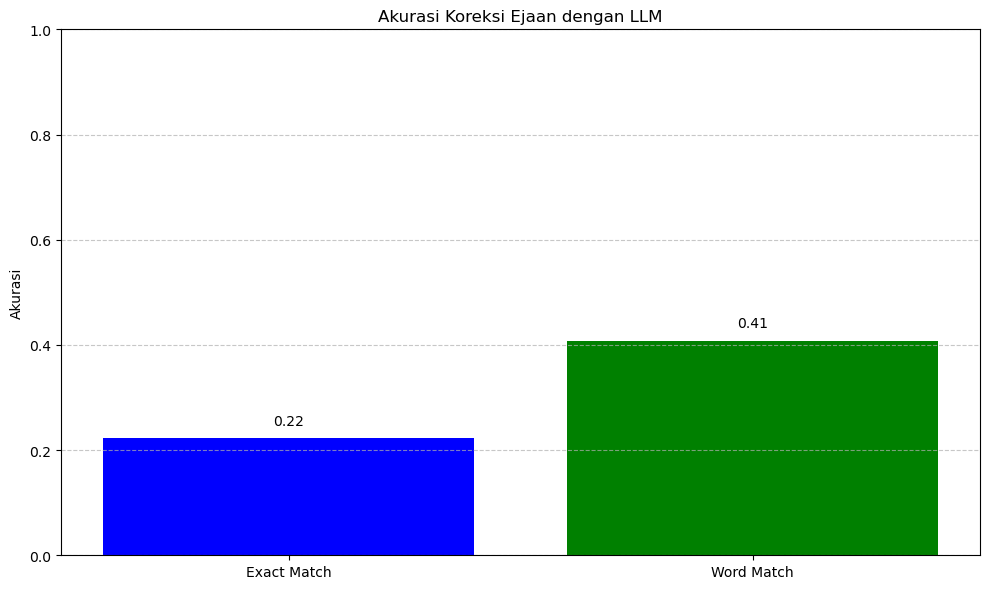

In [9]:
import matplotlib.pyplot as plt

# Hitung akurasi dengan kedua skema
exact_acc, exact_detail = skema_exact_match(hasil_llm_model1, kalimat_benar)
kata_acc, kata_detail = skema_kata_per_kata(hasil_llm_model1, kalimat_benar)

# Tampilkan hasil akurasi
print(f"====== Hasil Evaluasi ======")
print(f"Skema 1 - Exact Match Accuracy : {exact_acc:.4f}")
print(f"Skema 2 - Word Match Accuracy  : {kata_acc:.4f}")
print(f"Rata-rata waktu proses         : {np.mean(processing_times):.2f}s")

# Detail hasil per kalimat
print("\n====== Detail Hasil per Kalimat ======")
for i, (salah, benar, hasil, exact, kata_akurasi) in enumerate(zip(kalimat_salah, kalimat_benar, hasil_llm_model1, exact_detail, kata_detail)):
    status = "✓" if exact else "✗"
    print(f"{i+1}. {status} Kata Benar: {kata_akurasi:.2f}")
    print(f"   Input : {salah}")
    print(f"   Target: {benar}")
    print(f"   LLM   : {hasil}\n")

# Visualisasi
metrics = ['Exact Match', 'Word Match']
values = [exact_acc, kata_acc]
colors = ['blue', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.0)
plt.title('Akurasi Koreksi Ejaan dengan LLM')
plt.ylabel('Akurasi')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

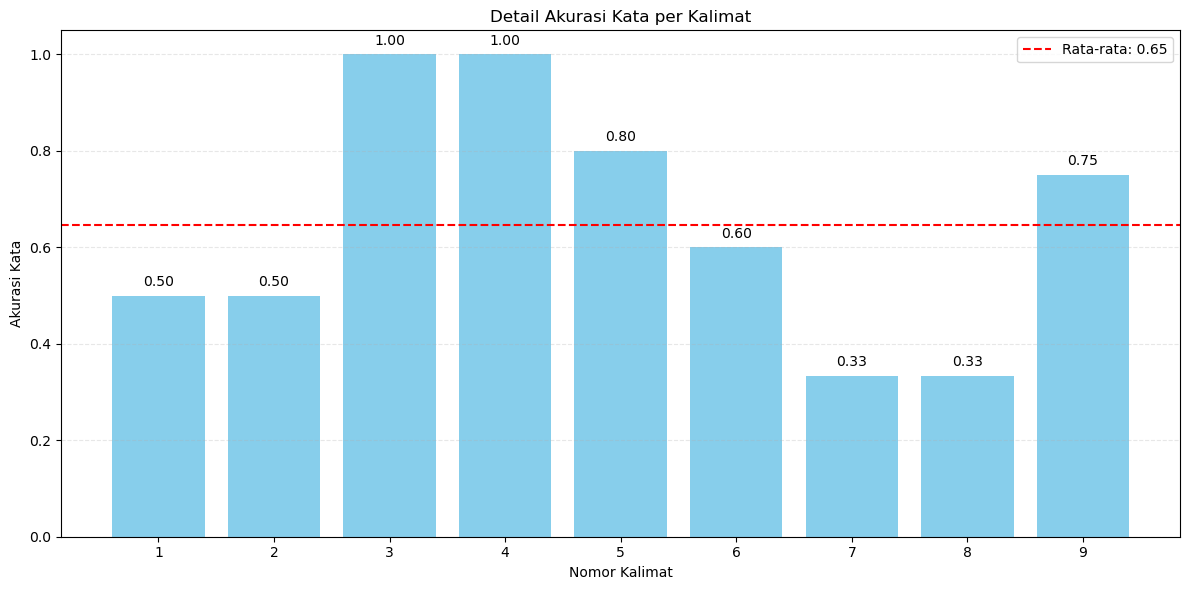

In [52]:
# Visualisasi detail akurasi kata per kalimat
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(kata_detail)+1), kata_detail, color='skyblue')
plt.axhline(y=kata_acc, color='r', linestyle='--', label=f'Rata-rata: {kata_acc:.2f}')
plt.xlabel('Nomor Kalimat')
plt.ylabel('Akurasi Kata')
plt.title('Detail Akurasi Kata per Kalimat')
plt.xticks(range(1, len(kata_detail)+1))
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, v in enumerate(kata_detail):
    plt.text(i+1, v+0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()